In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('new_pre.csv')
df

,Unnamed: 0,HAD_ATTACK,HAD_HEARTDIS,HAD_ASTHMA,KIDNEY_DIS,HAD_DIABETES,DIFFWALK,SMOKING100,DRINKSIN_30D,DRINK_FREQ30D,PHYSICH_STATUS,MENTALH_STATUS,HEALTH_INSU,PHYSIC_ACT,SEX,AGE>65,HEAVY_DRINKERS,Adult,WEIGHT_KG
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1,88.450440
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1,80.739376
2,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,98.429464
3,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,66.224432
4,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1,90.718400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184074,184074,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,71.667536
184075,184075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,58.966960
184076,184076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,90.718400
184077,184077,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,77.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,58.059776


# XG Boost

In [3]:
#XGBoost model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.utils import resample
from xgboost import XGBClassifier



for col in list(df.columns):
    if col.lower().startswith("unnamed"):
        df.drop(columns=[col], inplace=True)

target_col = "HAD_ATTACK"
df[target_col] = df[target_col].astype(int)


def make_6040(dataset, target):
    maj = dataset[dataset[target] == 0]
    minr = dataset[dataset[target] == 1]
    # keep all positives; sample negatives to 60:40
    desired_neg = int(len(minr) * (60/40))
    maj_down = maj.sample(n=min(desired_neg, len(maj)), random_state=42)
    return pd.concat([maj_down, minr]).sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced = make_6040(df, target_col)


X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42  # 0.25 of 0.8 = 0.2
)


train_df = pd.concat([X_train, y_train], axis=1)
maj = train_df[train_df[target_col] == 0]
minr = train_df[train_df[target_col] == 1]


minr_up = resample(minr, replace=True, n_samples=len(maj), random_state=42)
train_bal = pd.concat([maj, minr_up]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_bal.drop(columns=[target_col])
y_train_bal = train_bal[target_col].astype(int)



model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=3,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    reg_alpha=0.2,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist",
)

model.fit(X_train_bal, y_train_bal)


# -----------------------------
val_proba = model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)   
f1_vals = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0)


best_idx = np.argmax(f1_vals[:-1])
best_thr_f1 = float(thr[best_idx])


target_recall = 0.90
recall_mask = rec[:-1] >= target_recall
best_thr_r90 = float(thr[recall_mask][0]) if recall_mask.any() else best_thr_f1

best_thr = best_thr_f1  
print(f"Best tuned threshold (validation, F1): {best_thr_f1:.3f}")
if recall_mask.any():
    print(f"Threshold for Recall≥{target_recall:.2f}: {best_thr_r90:.3f}")



test_proba = model.predict_proba(X_test)[:, 1]
y_pred_test = (test_proba >= best_thr).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=3))

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual_0", "Actual_1"], columns=["Pred_0", "Pred_1"])
print("\nConfusion Matrix (Test Set):")
print(cm_df)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision (class 1)": precision_score(y_test, y_pred_test, zero_division=0),
    "Recall (class 1)": recall_score(y_test, y_pred_test, zero_division=0),
    "F1 (class 1)": f1_score(y_test, y_pred_test, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, test_proba),
}
print("\nOverall Metrics:")
for k, v in metrics.items():
    print(f"{k:25s}: {v:.3f}")


pd.DataFrame({
    "y_test": y_test.values,
    "proba": test_proba,
    "y_pred": y_pred_test
}).to_csv("xgb_tuned_predictions.csv", index=False)
print("\nPredictions saved to: xgb_tuned_predictions.csv")


Best tuned threshold (validation, F1): 0.397
Threshold for Recall≥0.90: 0.001

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.832     0.767     0.798      2234
           1      0.687     0.767     0.725      1489

    accuracy                          0.767      3723
   macro avg      0.759     0.767     0.761      3723
weighted avg      0.774     0.767     0.769      3723


Confusion Matrix (Test Set):
          Pred_0  Pred_1
Actual_0    1713     521
Actual_1     347    1142

Overall Metrics:
Accuracy                 : 0.767
Precision (class 1)      : 0.687
Recall (class 1)         : 0.767
F1 (class 1)             : 0.725
ROC AUC                  : 0.849

Predictions saved to: xgb_tuned_predictions.csv


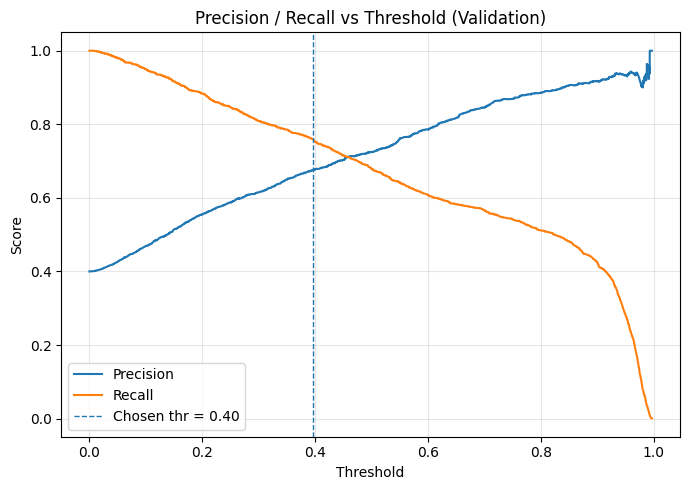

In [4]:
plt.figure(figsize=(7, 5))
plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.axvline(best_thr, ls="--", lw=1, label=f"Chosen thr = {best_thr:.2f}")
plt.title("Precision / Recall vs Threshold (Validation)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Ensemble model (XGBoost+LGBM+CatBoost)

In [ ]:


import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# ------------------------------------------------------------
#  Load & prepare data
# ------------------------------------------------------------

# Drop index-like columns if any
for col in list(df.columns):
    if col.lower().startswith("unnamed"):
        df.drop(columns=[col], inplace=True)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------------
#  Clean feature names (LightGBM-safe)
# ------------------------------------------------------------
def clean_columns(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

X_train = clean_columns(X_train)
X_test = clean_columns(X_test)

# ------------------------------------------------------------
#  Define base learners (Recall-Weighted Config)
# ------------------------------------------------------------
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)

lgb = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    objective='binary',
    random_state=42
)

cat = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=6,
    class_weights=[1, 3],   # more weight to positive class
    verbose=0,
    random_seed=42
)

# ------------------------------------------------------------
#  Build the ensemble (soft voting)
# ------------------------------------------------------------
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgb', lgb),
        ('cat', cat)
    ],
    voting='soft',
    weights=[1, 1, 2]  # Slightly more weight to CatBoost (usually better recall)
)

# ------------------------------------------------------------
#  Train the ensemble
# ------------------------------------------------------------
ensemble.fit(X_train, y_train)

# ------------------------------------------------------------
#  Threshold Tuning (for Recall Boost)
# ------------------------------------------------------------
y_pred_proba = ensemble.predict_proba(X_test)[:, 1]

threshold = 0.35   # Try 0.3–0.4 range for best recall
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# ------------------------------------------------------------
#  Evaluate performance
# ------------------------------------------------------------
print(f"\nEnsemble Model Performance (Threshold {threshold:.2f}):")
print(classification_report(y_test, y_pred_thresh, digits=3))

cm = confusion_matrix(y_test, y_pred_thresh)
cm_df = pd.DataFrame(cm, index=['Actual_0', 'Actual_1'], columns=['Pred_0', 'Pred_1'])
print("\nConfusion Matrix:")
print(cm_df)

print("\nAdditional Metrics:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred_thresh):.3f}")
print(f"Precision : {precision_score(y_test, y_pred_thresh):.3f}")
print(f"Recall    : {recall_score(y_test, y_pred_thresh):.3f}")
print(f"F1 Score  : {f1_score(y_test, y_pred_thresh):.3f}")
print(f"ROC AUC   : {roc_auc_score(y_test, y_pred_proba):.3f}")

# ------------------------------------------------------------
#  Precision–Recall Curve (Visualize tradeoff)
# ------------------------------------------------------------
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 5))
plt.plot(thresh, rec[:-1], label='Recall')
plt.plot(thresh, prec[:-1], label='Precision')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision–Recall Tradeoff Curve')
plt.show()
